In [1]:
from IPython.display import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import matplotlib.image as mpimg
import yaml
%matplotlib inline

In [2]:
def load_from_bin(bin_path):
    obj = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    # ignore reflectivity info
    return obj[:,:3]

In [3]:
def print_projection_plt(points, color, image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(hsv_image, (np.int32(points[0][i]),np.int32(points[1][i])),2, (int(color[i]),255,255),-1)

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

In [4]:
def depth_color(val, min_d=0, max_d=120):
    np.clip(val, 0, max_d, out=val) 
    return (((val - min_d) / (max_d - min_d)) * 120).astype(np.uint8) 
def points_filter(points,img_width,img_height,P,RT):
    ctl = RT
    ctl = np.array(ctl)
    fov_x = 2*np.arctan2(img_width, 2*P[0,0])*180/3.1415926+10
    fov_y = 2*np.arctan2(img_height, 2*P[1,1])*180/3.1415926+10
    R= np.eye(4)
    p_l = np.ones((points.shape[0],points.shape[1]+1))
    p_l[:,:3] = points
    p_c = np.matmul(ctl,p_l.T)
    p_c = p_c.T
    x = p_c[:,0]
    y = p_c[:,1]
    z = p_c[:,2]
    dist = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    xangle = np.arctan2(x, z)*180/np.pi;
    yangle = np.arctan2(y, z)*180/np.pi;
    flag2 = (xangle > -fov_x/2) & (xangle < fov_x/2)
    flag3 = (yangle > -fov_y/2) & (yangle < fov_y/2)
    res = p_l[flag2&flag3,:3]
    res = np.array(res)
    x = res[:, 0]
    y = res[:, 1]
    z = res[:, 2]
    dist = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    color = depth_color(dist, 0, 70)
    return res,color

In [5]:
def get_cam_mtx(filepath):
    data = np.loadtxt(filepath)
    P = np.zeros((3,3))
    P[0,0] = data[0]
    P[1,1] = data[1]
    P[2,2] = 1
    P[0,2] = data[2]
    P[1,2] = data[3]
    return P

In [6]:
def get_lidar2cam_mtx(filepath):
    with open(filepath,'r') as f:
        data = yaml.load(f,Loader= yaml.Loader)
    q = data['os1_cloud_node-pylon_camera_node']['q']
    q = np.array([q['x'],q['y'],q['z'],q['w']])
    t = data['os1_cloud_node-pylon_camera_node']['t']
    t = np.array([t['x'],t['y'],t['z']])
    R_vc = Rotation.from_quat(q)
    R_vc = R_vc.as_matrix()

    RT = np.eye(4,4)
    RT[:3,:3] = R_vc
    RT[:3,-1] = t
    RT = np.linalg.inv(RT)
    return RT

In [7]:
image = cv2.imread('./example/frame000104-1581624663_149.jpg')
points = load_from_bin('./example/000104.bin')
img_height, img_width, channels = image.shape
distCoeff = np.array([-0.134313,-0.025905,0.002181,0.00084,0])
distCoeff = distCoeff.reshape((5,1))
P = get_cam_mtx('./example/camera_info.txt')
print(P)

[[2.81364327e+03 0.00000000e+00 9.69285772e+02]
 [0.00000000e+00 2.80832608e+03 6.24049972e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


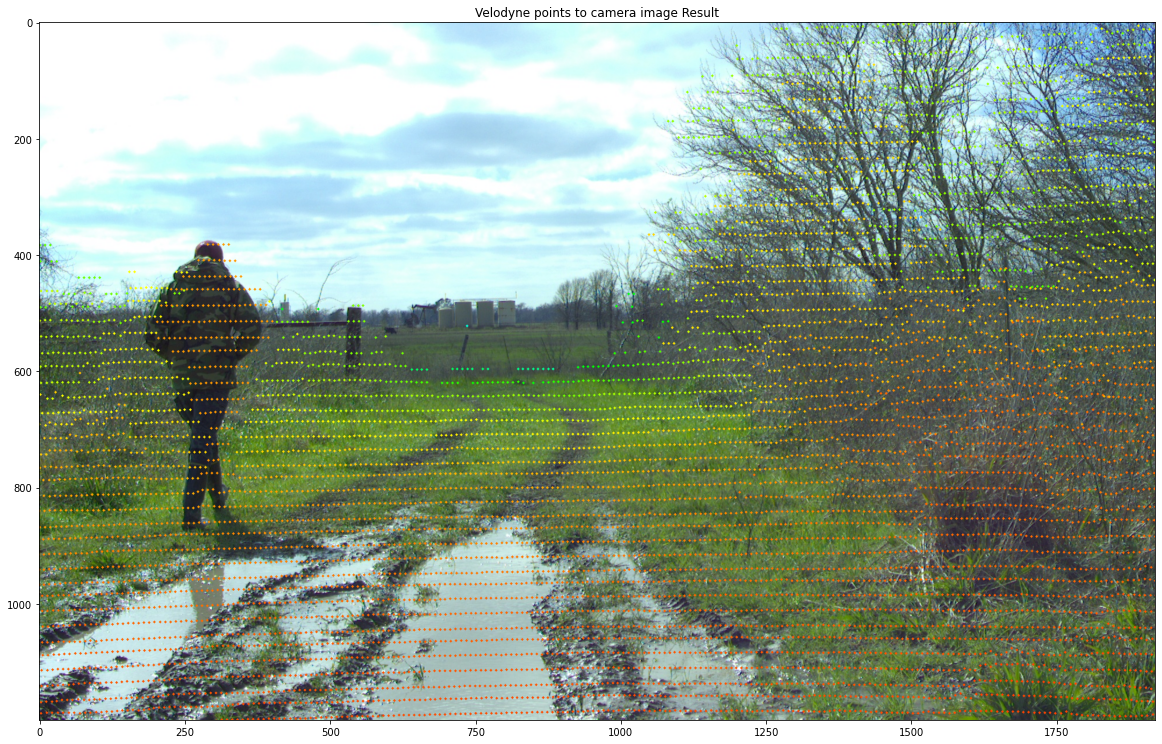

In [8]:
RT= get_lidar2cam_mtx('./example/transforms.yaml')
R_vc = RT[:3,:3]
T_vc = RT[:3,3]
T_vc = T_vc.reshape(3, 1)
rvec,_ = cv2.Rodrigues(R_vc)
tvec = T_vc
xyz_v, c_ = points_filter(points,img_width,img_height,P,RT)

imgpoints, _ = cv2.projectPoints(xyz_v[:,:],rvec, tvec, P, distCoeff)
imgpoints = np.squeeze(imgpoints,1)
imgpoints = imgpoints.T
res = print_projection_plt(points=imgpoints, color=c_, image=image)

plt.subplots(1,1, figsize = (20,20) )
plt.title("Velodyne points to camera image Result")
plt.imshow(res)